<a href="https://colab.research.google.com/github/FatimaDahwi/SignEase-Sign-Language-learning-Platform/blob/main/SignEase_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ================================
# Cell 1: Import Libraries
# ================================

# Description:
# Import all essential libraries for image processing, model building, and performance optimization
# Command: Run this cell to load the libraries

import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau



print("Libraries imported successfully!")


Libraries imported successfully!


In [ ]:
# Description:
# Install mediapipe and import required libraries for landmark extraction

!pip install mediapipe

import mediapipe as mp
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
# ================================
# Cell 2: Define Dataset Paths
# ================================

# Description:
# Set the paths for training and testing dataset folders + mount to drive
# Command: Adjust these paths according to your Google Drive structure

from google.colab import drive
drive.mount('/content/drive')


train_dir = '/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/'
test_dir  = '/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_test/asl_alphabet_test/'

print("Train directory:", train_dir)
print("Test directory:", test_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train directory: /content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/
Test directory: /content/drive/MyDrive/SignEase_Dataset/asl_alphabet_test/asl_alphabet_test/


In [ ]:
# Description:
# This function takes an image, finds the hand, and extracts 21 landmark points if available.

def extract_landmarks(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    if result.multi_hand_landmarks:
        landmarks = []
        for lm in result.multi_hand_landmarks[0].landmark:
            landmarks.extend([lm.x, lm.y, lm.z])
        return landmarks
    else:
        return None


In [ ]:
# Description:
# Loop through all folders, extract hand landmarks, and store in CSV file.

data = []
labels = []

classes = sorted([c for c in os.listdir(train_dir) if c.lower() != "del"])
  # A, B, C, ...
print("Classes found:", classes)

for label in classes:
    folder_path = os.path.join(train_dir, label)
    for img_file in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        img_path = os.path.join(folder_path, img_file)
        landmarks = extract_landmarks(img_path)
        if landmarks:
            data.append(landmarks)
            labels.append(label)

df = pd.DataFrame(data)
df['label'] = labels
df.to_csv('/content/asl_landmarks.csv', index=False)

print("\n✅ Done! Saved as: /content/asl_landmarks.csv")


Classes found: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


Processing space: 100%|██████████| 3000/3000 [03:13<00:00, 15.51it/s]



✅ Done! Saved as: /content/asl_landmarks.csv


In [ ]:
# Load the CSV file
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

df = pd.read_csv('/content/asl_landmarks.csv')

# Separate features (X) and labels (y)
X = df.drop('label', axis=1).values
y = df['label'].values

# Encode labels into numbers
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("Number of classes:", len(np.unique(y)))


X_train: (49580, 63)
X_test: (12395, 63)
Number of classes: 28


In [ ]:
#Build the Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = len(np.unique(y))

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 28)             │         3,612 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,892 (206.61 KB)

 Trainable params: 52,892 (206.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#train with callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('asl_landmarks_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/50
1543/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4351 - loss: 1.9384
Epoch 1: val_accuracy improved from -inf to 0.93812, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.4362 - loss: 1.9343 - val_accuracy: 0.9381 - val_loss: 0.3317
Epoch 2/50
1537/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.3927
Epoch 2: val_accuracy improved from 0.93812 to 0.95272, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8782 - loss: 0.3924 - val_accuracy: 0.9527 - val_loss: 0.2024
Epoch 3/50
1542/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9154 - loss: 0.2750
Epoch 3: val_accuracy improved from 0.95272 to 0.96273, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9155 - loss: 0.2749 - val_accuracy: 0.9627 - val_loss: 0.1556
Epoch 4/50
1539/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9303 - loss: 0.2291
Epoch 4: val_accuracy improved from 0.96273 to 0.96555, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9303 - loss: 0.2291 - val_accuracy: 0.9656 - val_loss: 0.1369
Epoch 5/50
1548/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9390 - loss: 0.1987
Epoch 5: val_accuracy improved from 0.96555 to 0.96660, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9390 - loss: 0.1987 - val_accuracy: 0.9666 - val_loss: 0.1285
Epoch 6/50
1537/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9435 - loss: 0.1825
Epoch 6: val_accuracy improved from 0.96660 to 0.96700, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9435 - loss: 0.1825 - val_accuracy: 0.9670 - val_loss: 0.1249
Epoch 7/50
1545/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9455 - loss: 0.1742
Epoch 7: val_accuracy improved from 0.96700 to 0.97297, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9455 - loss: 0.1742 - val_accuracy: 0.9730 - val_loss: 0.1159
Epoch 8/50
1541/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9489 - loss: 0.1657
Epoch 8: val_accuracy did not improve from 0.97297
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9489 - loss: 0.1657 - val_accuracy: 0.9610 - val_loss: 0.1293
Epoch 9/50
1540/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9491 - loss: 0.1597
Epoch 9: val_accuracy did not improve from 0.97297
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9491 - loss: 0.1597 - val_accuracy: 0.9673 - val_loss: 0.1138
Epoch 10/50
1547/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9520 - loss: 0.1508
Epoch 10: val_accuracy did not improve from 0.97297
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9520 - loss: 0.1508 - val_accuracy: 0.9724 - val_loss: 0.1055
Epoch 11/50
1538/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9530 - loss: 0.1498
Epoch 11: val_

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9530 - loss: 0.1497 - val_accuracy: 0.9740 - val_loss: 0.1026
Epoch 12/50
1544/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9527 - loss: 0.1500
Epoch 12: val_accuracy improved from 0.97402 to 0.98104, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9528 - loss: 0.1500 - val_accuracy: 0.9810 - val_loss: 0.0873
Epoch 13/50
1542/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9562 - loss: 0.1420
Epoch 13: val_accuracy did not improve from 0.98104
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9562 - loss: 0.1420 - val_accuracy: 0.9718 - val_loss: 0.1105
Epoch 14/50
1548/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9556 - loss: 0.1392
Epoch 14: val_accuracy did not improve from 0.98104
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9556 - loss: 0.1392 - val_accuracy: 0.9787 - val_loss: 0.0891
Epoch 15/50
1548/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9601 - loss: 0.1290
Epoch 15: val_accuracy did not improve from 0.98104
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9601 - loss: 0.1290 - val_accuracy: 0.9768 - val_loss: 0.0926
Epoch 16/50
1541/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9575 - loss: 0.1355
Epoch 16: va

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9596 - loss: 0.1264 - val_accuracy: 0.9825 - val_loss: 0.0753
Epoch 22/50
1547/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9642 - loss: 0.1158
Epoch 22: val_accuracy improved from 0.98249 to 0.98314, saving model to asl_landmarks_model.h5


1550/1550 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9642 - loss: 0.1158 - val_accuracy: 0.9831 - val_loss: 0.0741
Epoch 23/50
1540/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9630 - loss: 0.1148
Epoch 23: val_accuracy did not improve from 0.98314
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9630 - loss: 0.1148 - val_accuracy: 0.9772 - val_loss: 0.0842
Epoch 24/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9643 - loss: 0.1159
Epoch 24: val_accuracy did not improve from 0.98314
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9643 - loss: 0.1159 - val_accuracy: 0.9818 - val_loss: 0.0781
Epoch 25/50
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9625 - loss: 0.1207
Epoch 25: val_accuracy did not improve from 0.98314
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9625 - loss: 0.1207 - val_accuracy: 0.9795 - val_loss: 0.0853
Epoch 26/50
1549/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9658 - loss: 0.1128
Epoch 26: va

In [ ]:
#Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc*100:.2f}%")


Test Accuracy: 98.31%


In [ ]:
model.save('/content/drive/MyDrive/SignEase_Model/asl_model.h5')


In [ ]:

model.save('/content/drive/MyDrive/SignEase_Model/asl_model.keras')


In [ ]:
import cv2
import numpy as np
import mediapipe as mp

import os

train_folder = '/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train'
class_names = sorted([d for d in os.listdir(train_folder) if os.path.isdir(os.path.join(train_folder, d))])
print(class_names)

# 1️⃣ المسار للصورة
img_path ='/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/M/M175.jpg'

# 2️⃣ إعداد MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# 3️⃣ قراءة الصورة
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 4️⃣ استخراج keypoints
results = hands.process(img_rgb)

if results.multi_hand_landmarks:
    hand_landmarks = results.multi_hand_landmarks[0]
    keypoints = []
    for lm in hand_landmarks.landmark:
        keypoints.extend([lm.x, lm.y, lm.z])
    keypoints = np.array(keypoints).reshape(1, 63)  # شكل مناسب للموديل

    # 5️⃣ prediction باستخدام الموديل اللي انت دربته
    predictions = model.predict(keypoints)
    class_index = np.argmax(predictions)
    print("Predicted Class:", class_names[class_index])
else:
    print("No hand detected")


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted Class: M


In [ ]:
import os

img_path ='/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/B/B2681.jpg'

if not os.path.exists(img_path):
    print("File does not exist:", img_path)
else:
    print("File exists, ready to read")


File exists, ready to read


In [ ]:
import os

folder_path = '/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/A'

# نحصل على كل الملفات في الفولدر
files = os.listdir(folder_path)

if len(files) == 0:
    print("The folder is empty!")
else:
    print("The folder has", len(files), "files:")
    print(files)


The folder has 3000 files:
['A2681.jpg', 'A2671.jpg', 'A2710.jpg', 'A2885.jpg', 'A2773.jpg', 'A284.jpg', 'A2790.jpg', 'A2659.jpg', 'A2880.jpg', 'A2875.jpg', 'A2719.jpg', 'A2767.jpg', 'A2852.jpg', 'A2654.jpg', 'A2824.jpg', 'A2639.jpg', 'A2742.jpg', 'A2811.jpg', 'A2816.jpg', 'A2769.jpg', 'A2619.jpg', 'A267.jpg', 'A2640.jpg', 'A2649.jpg', 'A2777.jpg', 'A2667.jpg', 'A2869.jpg', 'A2796.jpg', 'A2722.jpg', 'A2729.jpg', 'A2691.jpg', 'A2783.jpg', 'A2872.jpg', 'A2766.jpg', 'A2650.jpg', 'A2821.jpg', 'A2789.jpg', 'A28.jpg', 'A2724.jpg', 'A2808.jpg', 'A2755.jpg', 'A2626.jpg', 'A2754.jpg', 'A2688.jpg', 'A266.jpg', 'A2862.jpg', 'A2859.jpg', 'A2621.jpg', 'A2843.jpg', 'A2794.jpg', 'A2713.jpg', 'A2634.jpg', 'A2883.jpg', 'A2831.jpg', 'A2711.jpg', 'A2686.jpg', 'A2717.jpg', 'A2786.jpg', 'A2828.jpg', 'A2781.jpg', 'A2770.jpg', 'A283.jpg', 'A2772.jpg', 'A2763.jpg', 'A2761.jpg', 'A2653.jpg', 'A2715.jpg', 'A262.jpg', 'A2805.jpg', 'A2694.jpg', 'A2696.jpg', 'A2863.jpg', 'A2864.jpg', 'A2655.jpg', 'A2648.jpg', 'A28

Class distribution: {'B': 3000, 'A': 3000, 'C': 3000, 'D': 3000, 'del': 3000, 'I': 3000, 'G': 3000, 'H': 3000, 'M': 3000, 'L': 3000, 'K': 3000, 'J': 3000, 'O': 3000, 'nothing': 3000, 'R': 3000, 'N': 3000, 'Q': 3000, 'P': 3000, 'S': 3000, 'space': 3000, 'X': 3000, 'Z': 3000, 'V': 3000, 'U': 3000, 'W': 3000, 'Y': 3000, 'T': 3000, 'E': 3000, 'F': 3000}


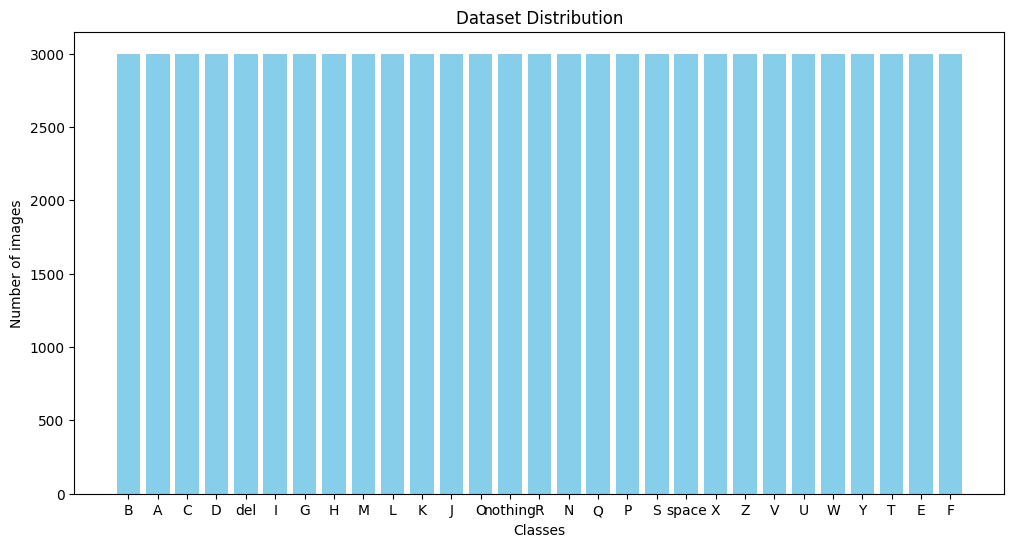

In [ ]:
import os
import matplotlib.pyplot as plt

dataset_path = "/content/drive/MyDrive/SignEase_Dataset/asl_alphabet_train/asl_alphabet_train/"  # change to your folder path

# Count images per class
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

# Print counts
print("Class distribution:", class_counts)

# Plot distribution
plt.figure(figsize=(12,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of images")
plt.title("Dataset Distribution")
plt.show()


In [ ]:
import re
import matplotlib.pyplot as plt

log_file = "/content/drive/MyDrive/SignEase_Model/asl_training_log.txt"

# Lists to store metrics
train_acc, val_acc = [], []
train_loss, val_loss = [], []

with open(log_file, "r") as f:
    for line in f:
        # Extract training accuracy
        m_acc = re.search(r"accuracy: ([0-9.]+)", line)
        if m_acc:
            train_acc.append(float(m_acc.group(1)))

        # Extract training loss
        m_loss = re.search(r"loss: ([0-9.]+)", line)
        if m_loss:
            train_loss.append(float(m_loss.group(1)))

        # Extract validation accuracy
        m_val_acc = re.search(r"val_accuracy: ([0-9.]+)", line)
        if m_val_acc:
            val_acc.append(float(m_val_acc.group(1)))

        # Extract validation loss
        m_val_loss = re.search(r"val_loss: ([0-9.]+)", line)
        if m_val_loss:
            val_loss.append(float(m_val_loss.group(1)))

# Make sure all lists are the same length
min_len = min(len(train_acc), len(val_acc), len(train_loss), len(val_loss))
train_acc, val_acc = train_acc[:min_len], val_acc[:min_len]
train_loss, val_loss = train_loss[:min_len], val_loss[:min_len]

epochs = range(1, min_len+1)


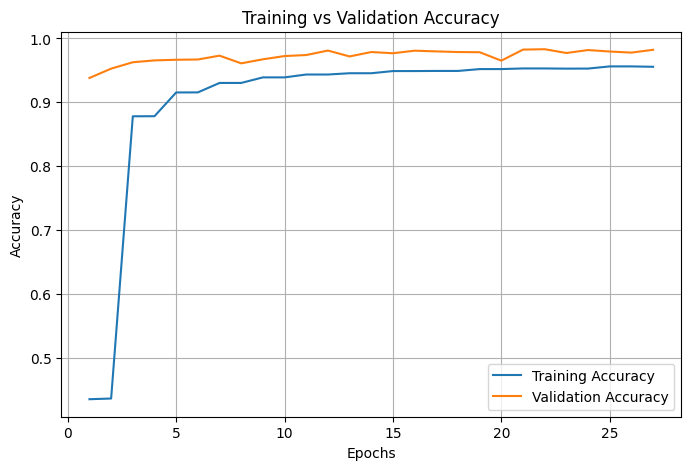

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


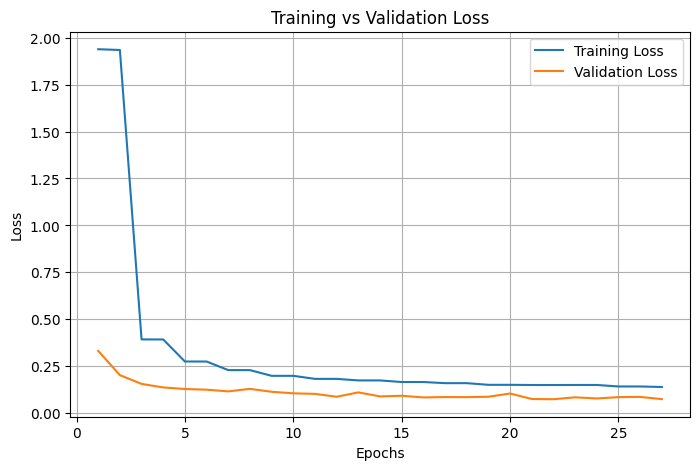

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import re
import matplotlib.pyplot as plt

log_file = "/content/drive/MyDrive/SignEase_Model/asl_training_log.txt"
train_acc, val_acc = [], []
train_loss, val_loss = [], []

with open(log_file, "r") as f:
    for line in f:
        # Match final epoch summary line only
        if " - accuracy:" in line and "val_accuracy" in line:
            acc = re.search(r"accuracy: ([0-9.]+)", line)
            loss = re.search(r"loss: ([0-9.]+)", line)
            v_acc = re.search(r"val_accuracy: ([0-9.]+)", line)
            v_loss = re.search(r"val_loss: ([0-9.]+)", line)

            if acc and loss and v_acc and v_loss:
                train_acc.append(float(acc.group(1)))
                train_loss.append(float(loss.group(1)))
                val_acc.append(float(v_acc.group(1)))
                val_loss.append(float(v_loss.group(1)))

epochs = range(1, len(train_acc) + 1)

print(f"Parsed {len(train_acc)} epochs successfully.")


Parsed 27 epochs successfully.


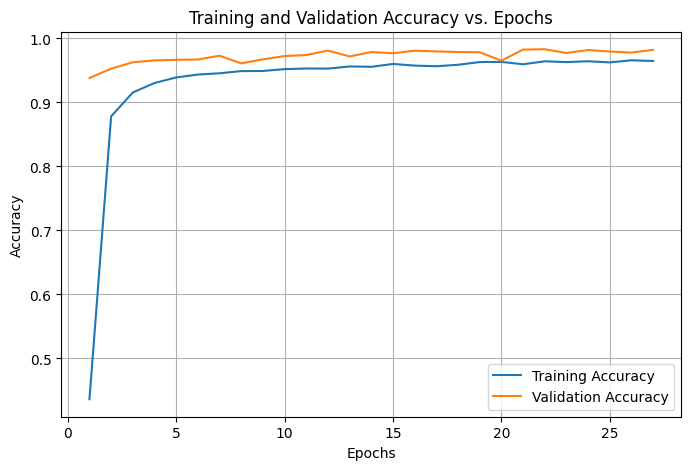

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()


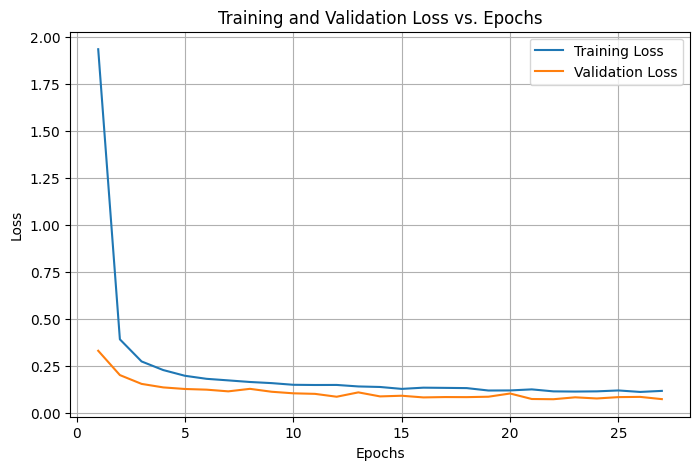

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epochs')
plt.legend()
plt.grid(True)
plt.show()
